# Natural Language Processing with Disaster Tweets

https://www.kaggle.com/c/nlp-getting-started/data

In [1]:
import numpy as np
import os
import pandas as pd


data_fp = os.path.join(os.getcwd(), "data")
train_fp = os.path.join(data_fp, "train.csv")
train_full = pd.read_csv(train_fp, encoding="utf-8")
test_fp = os.path.join(data_fp, "test.csv")
test = pd.read_csv(test_fp, encoding="utf-8")

print(f"Train: {train_full.shape}")
print(f"Test:  {test.shape}")

train_full.head()

Train: (7613, 5)
Test:  (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Kaggle supplies the test set (without target labels), so we will submit our final predictions there to get the ultimate measure of model performance. We separate 20% of the training data as a validation set.

In [2]:
# Shuffle the index in case there are patterns in the order of the training data:
np.random.seed(42)
shuffled_ix = list(train_full.index)
np.random.shuffle(shuffled_ix)
cutoff = int(len(shuffled_ix)*0.8)
train = train_full.loc[shuffled_ix[:cutoff]].copy()
validation = train_full.loc[shuffled_ix[cutoff:]].copy()

## Base Model

We use CountVectorizer and BernoulliNB to create a baseline model, and get benchmark score against the validation set.

Note that the target labels are binary outcomes, so they comrpise a Bernoulli distribution where $p \approx 0.43$. Therefore accuracy is the chosen metric of performance, since there isn't a huge class imbalance.

Bernoulli distribution, p = 0.43
Mean accuracy on 5-fold cross validation = 0.80
Validation accuracy = 0.79


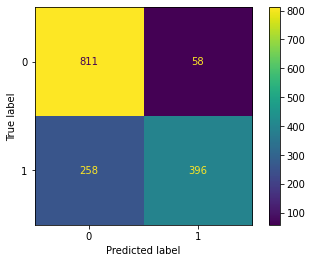

In [3]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import BernoulliNB


cv = CountVectorizer()
cv.fit(train["text"])
train_arr = cv.transform(train["text"])
train_labels = train["target"]
print(f"Bernoulli distribution, p = {train_labels.mean():.2f}")
model = BernoulliNB()
crossval = cross_validate(model, train_arr, train_labels, cv=5, return_estimator=True)
mean_score = crossval["test_score"].mean()
print(f"Mean accuracy on 5-fold cross validation = {mean_score:.2f}")
best_estimator = crossval["estimator"][crossval["test_score"].argmax()]
val_arr = cv.transform(validation["text"])
val_labels = validation["target"]
val_score = best_estimator.score(val_arr, val_labels)
print(f"Validation accuracy = {val_score:.2f}")
cm = plot_confusion_matrix(best_estimator, val_arr, val_labels)

## Approach

To improve performance we explore 2 different avenues:

1. How the text data is represented. Specifically we use word embeddings.
2. What type of model is used to learn the relationships between embeddings and the target feature.

Specifically for part 1, the following word embedding schemes are explored:

1. Word2Vec - pretrained
2. Word2Vec - corpus trained

For part 2, based on the results of <a href="https://github.com/MIDS-W207/coursework/blob/master/Readings/Week%2008/An%20Empirical%20Comparison%20of%20Supervised%20Learning%20Algorithms.pdf">this</a> paper comparing the performance of classifiers, we try out the following 3 classifiers:

1. Boosted Trees
2. Support Vector Machines
3. Neural Networks

## Pre-Processing

Since we are using Word Embeddings, we'll need to standardize the format of the input tweets. From the creators of the dataset there is a <a href="https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb">Ruby script</a>, which has been converted to <a href="https://www.kaggle.com/amackcrane/python-version-of-glove-twitter-preprocess-script">Python</a> by a Kaggle user. The below method is adapted from this Python version, with some additional changes to improve the number of input words which can be embedded. Some of these changes include:

1. Removing most punctuation entirely. The original Kaggle script leaves a lot of punctation untouched, so that for example the quoted word `'something'` would be included as a separate feature to the unquoted word `something`. We make the assumption that such differences in punctuation of features are unlikely to be significant in identifying disaster tweets.
2. Fixing a couple of bugs with the way whitespace was added around certain punctuation marks, such as `.,`
3. Add spaces around inserted tags such as ` <number> `

Making the above changes to the preprocessor we increase the number of input words which are found in the embedding vocabulary from ~75% to nearly 90%.

One interesting decision in the preprocessing script is to remove tagged twitter usernames (i.e. strings starting with `@`), since you might expect that this could provide some useful information in trying to predict the nature of the tweets. For example, a tweet tagging a local fire department might be much more likely to be a disaster related tweet. However on searching the word embedding features for well known Twitter usernames (e.g. `@realdonaldtrump`) we find that they are not present, so this seems to accord with the processing done for the Glove word embeddings.

In [4]:

import string
import sys
import regex as re

FLAGS = re.MULTILINE | re.DOTALL


punctuation = string.punctuation.replace("#", "")
punctuation = punctuation.replace("<", "")
punctuation = punctuation.replace(">", "")


def _hashtag(text):
    """Parse hashtags in tweets.
    
    For hashtags with words in title case, splits into separate words, e.g.
        #BigFire -> <hashtag> Big Fire 
        
    For all caps hashtags converts to lowercase, e.g.
        #OMG -> <hashtag> omg
    """
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = f" <hashtag> {hashtag_body.lower()} <allcaps> "
    else:
        result = " ".join([" <hashtag> "] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return result


def _allcaps(text):
    """Convert all-caps words to lowercase and add allcaps tag."""
    text = text.group()
    return text.lower() + " <allcaps> "


def tokenize(text):
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    # Remove URLS:
    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", " <url> ")
    
    # Remove usernames:
    text = re_sub(r"@\w+", " <user> ")
    
    # Tag smiley faces :-) sad faces :-( etc.
    eyes, nose = r"[8:=;]", r"['`\-]?"
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), " <smile> ")
    text = re_sub(r"{}{}p+".format(eyes, nose), " <lolface> ")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), " <sadface> ")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), " <neutralface> ")
    text = re_sub(r"<3"," <heart> ")

    # Add whitespace around /
    text = re_sub(r"/"," / ")
    
    # Tag numbers:
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", " <number> ")
    
    # Tag hastags and separate hashtag words:
    text = re_sub(r"#\w+", _hashtag)
    
    # Remove and tag repetitions of question marks, exclamations:
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat> ")
    
    # Tag elongated sequences of the same letter (3+ occurences), e.g. "AAAAAAA"
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong> ")
    
    # Put whitespace around punctuation, then remove:
    text = re_sub(r"([a-zA-Z<>()])([{}])".format(punctuation), r"\1 \2")
    text = re_sub(r"([{}])([a-zA-Z<>()])".format(punctuation), r"\1 \2")
    text = re.sub("[%s]" % re.escape(punctuation), "", text)

    # Tag all caps words:
    text = re_sub(r" ([A-Z]){2,} ", _allcaps)
    
    return " ".join(text.lower().split())

In [5]:
# Example with lots of weird features:
text = "#BigFire on #MountEverest #OMG, !! /where are police 'some' punctuation! 3now 44 @police"
tokenize(text)

'<hashtag> <elong> big fire on <hashtag> <elong> mount everest <hashtag> omg <allcaps> <repeat> where are police some punctuation <number> now <number> <user>'

In [6]:
# Example from the dataset:
example_tweet = train["text"][0]
print("Original Tweet:\n", f"  {example_tweet}\n")
print("Kaggle user script:\n", f"{tokenize(example_tweet)}\n")

Original Tweet:
   Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

Kaggle user script:
 our deeds are the reason of this <hashtag> earthquake may allah <allcaps> forgive us all



## Word Embeddings

We use word embeddings to convert each word to a $d$-length vector. Because the models we are using require a single vector input, we need a way to then convert the multiple word embeddings for a single tweet into one vector. Using the suggestion <a href="https://stats.stackexchange.com/a/239071/115143">here</a>, we try 2 approaches:

1. Take the simple average of the vectors for all words in the tweet (resulting in vector of length $d$).
2. Concatenate the coordinate-wise minimum and maximum values in each word vector (resulting in vector of length $2d$).

In [7]:

from gensim.models.keyedvectors import KeyedVectors
import numpy as np
from spellchecker import SpellChecker
import yaml


def correct_spellings(words: list):
    """Use pyspellchecker to save a dictionary of unknown words
    to corrected spellings, or just load presaved corrections. 
    See:
        https://github.com/barrust/pyspellchecker
    """
    fp = os.path.join(os.getcwd(), "spelling_corrections.yaml")
    if not os.path.exists(fp):
        corrections = dict()
        with open(fp, "w") as stream:
            yaml.safe_dump(corrections, stream)
    else:
        with open(fp, "r") as stream:
            corrections = yaml.safe_load(stream)
        if corrections is None:
            corrections = dict()
    to_correct = [w for w in words if w not in corrections]
    if to_correct:
        spell = SpellChecker()
        new = {w: spell.correction(w) for w in to_correct}
        corrections = {**corrections, **new}
        with open(fp, "w") as stream:
            yaml.safe_dump(corrections, stream)
        print(f"Saved {len(new):} spelling corrections to file.")
    return corrections


class WordEmbeddings:
    
    def __init__(self, X: pd.Series, embeddings: KeyedVectors, processor = tokenize):
        
        # Apply the preprocessor function:
        X = X.map(processor).tolist()
        
        # Apply the spelling corrections:
        corrections = correct_spellings([])
        corrected = list()
        for tweet in X:
            corrected.append(" ".join([corrections.get(w, w) for w in tweet.split()]))
            
        self.X = corrected
        self.embeddings = embeddings
        
        # Unique vocabulary of the embedding scheme:
        self.embeddings_vocab = set(embeddings.key_to_index)
        
        # Unique vocabulary of the inputs:
        self.X_vocab = {w for words in [s.split() for s in X] for w in words}
        
        # Unknown words in the input:
        self.unknown_words = self.X_vocab - self.embeddings_vocab

        # Common vocabulary between the input and the embeddings scheme:
        self.common_vocab = self.embeddings_vocab & self.X_vocab
        self.vocab_coverage = len(self.common_vocab) / len(self.X_vocab)
        print(f"{len(self.X_vocab):} processed input words, "\
              f"{len(self.common_vocab):} found in embeddings "\
              f"({self.vocab_coverage*100:.2f}%).")

        # Lookup table from words to their embeddings:
        self.embeddings_table = pd.DataFrame(embeddings[self.common_vocab], index=self.common_vocab).sort_index()
        
        # Iterate through input tweets removing unknown words, creating average/min/max embeddings:
        embedding_mu, embedding_max, embedding_min, clean_tweets = list(), list(), list(), list()
        for i, tweet in enumerate(self.X):
            
            # Remove unknown words:
            words = tweet.split()
            known_words = [w for w in words if w in self.common_vocab]
            clean_tweets.append(" ".join(known_words))
            
            # Calculate mean of all word embeddings in tweet:
            mean_array = self.embeddings_table.loc[known_words].mean().values
            embedding_mu.append(mean_array)
            
            # Calculate min/max of all word embeddings in tweet:
            max_array = self.embeddings_table.loc[known_words].max().values
            embedding_max.append(max_array)
            min_array = self.embeddings_table.loc[known_words].min().values
            embedding_min.append(min_array)
            
        # Arrays of final X datasets in word embedding formats:
        self.embedding_mu = pd.DataFrame(np.array(embedding_mu))
        self.embedding_min = np.array(embedding_min)
        self.embedding_max = np.array(embedding_max)
        self.embedding_minmax = pd.DataFrame(np.concatenate([self.embedding_min, self.embedding_max], axis=1))
        
    @property
    def embedding_chars(self):
        """Unique characters in the word embeddings."""
        return "".join(sorted(set([c for w in self.embeddings.index_to_key for c in w])))


### Word2Vec

Using a pretrained Twitter Word2Vec model with ~1.2m word vocabulary:

In [8]:
from gensim import downloader


# Load the pretrained word embeddings (this takes a while):
glove_twitter = downloader.load("glove-twitter-200")
info = downloader.info()
print(info["models"]["glove-twitter-200"]["description"])

Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https://nlp.stanford.edu/projects/glove/).


In [9]:
# Use the WordEmbeddings class to apply embeddings to the training & validation data:
train_we = WordEmbeddings(train["text"], glove_twitter)
validation_we = WordEmbeddings(validation["text"], glove_twitter)

12481 processed input words, 11140 found in embeddings (89.26%).
5539 processed input words, 5128 found in embeddings (92.58%).


## Neural Network

In [10]:
from sklearn.neural_network import MLPClassifier

nn_minmax = MLPClassifier(hidden_layer_sizes=100, activation="relu", max_iter=400)
X_train_minmax = train_we.embedding_minmax.fillna(0)
nn_minmax.fit(X_train_minmax, train_labels)
nn_minmax.score(X_train_minmax, train_labels)

0.9853858784893268

In [11]:
X_validation_minmax = validation_we.embedding_minmax.fillna(0)
nn_minmax.score(X_validation_minmax, val_labels)

0.7583716349310571

In [12]:
nn_mu = MLPClassifier(hidden_layer_sizes=100, activation="relu", max_iter=400)
X_train_mu = train_we.embedding_mu.fillna(0)
nn_mu.fit(X_train_mu, train_labels)
nn_mu.score(X_train_mu, train_labels)

0.9866995073891626

In [13]:
X_validation_mu = validation_we.embedding_mu.fillna(0)
nn_mu.score(X_validation_mu, val_labels)

0.7570584372948129

Network is overfitting, so try decreasing iterations and increasing alpha parameter:

In [14]:
nn_minmax = MLPClassifier(hidden_layer_sizes=50, activation="relu", max_iter=200, alpha=0.1)
nn_minmax.fit(X_train_minmax, train_labels)
nn_minmax.score(X_train_minmax, train_labels)

/Users/tp/virtualenvs/mids-w207-group-project/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8924466338259441

In [15]:
nn_minmax.score(X_validation_minmax, val_labels)

0.7570584372948129

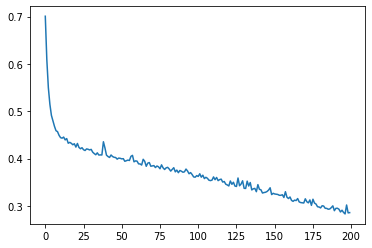

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(nn_minmax.loss_curve_)

Try with TensorFlow to tune model and prevent over-fitting:

In [17]:

import tensorflow as tf


class TfModel:
    
    def __init__(self, X_train, y_train, X_val, y_val, epochs: int = 100):
        """Implement a TensorFlow model over the training and validation data."""
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(2)
        ])

        self.model.compile(
            optimizer="adam",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["accuracy"]
        )

        self.history = self.model.fit(
            x=X_train,
            y=y_train,
            batch_size=512,
            verbose=2,
            validation_data=(X_val, y_val),
            epochs=epochs,
        )
        
        # Use probabilities to make predictions on validation set:
        self.proba_model = tf.keras.Sequential([
            self.model, 
            tf.keras.layers.Softmax()
        ])
        self.proba_predictions = self.proba_model.predict(X_val)
        self.predictions = np.argmax(self.proba_predictions, axis=1)
        
        # Store false positives/negatives:
        is_fp = np.where((y_val == 0) & (self.predictions == 1), 1, 0)
        self.false_positives = X_val.iloc[is_fp == 1]
        is_fn = np.where((y_val == 1) & (self.predictions == 0), 1, 0)
        self.false_negatives = X_val.iloc[is_fn == 1]


In [18]:
# Minmax word embeddings:
minmax_model = TfModel(X_train_minmax, train_labels, X_validation_minmax, val_labels)

2021-07-25 21:14:15.772665: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-25 21:14:16.137097: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
12/12 - 1s - loss: 0.6794 - accuracy: 0.6018 - val_loss: 0.5963 - val_accuracy: 0.6868
Epoch 2/100
12/12 - 0s - loss: 0.5650 - accuracy: 0.7287 - val_loss: 0.5420 - val_accuracy: 0.7321
Epoch 3/100
12/12 - 0s - loss: 0.5126 - accuracy: 0.7626 - val_loss: 0.5160 - val_accuracy: 0.7380
Epoch 4/100
12/12 - 0s - loss: 0.4941 - accuracy: 0.7645 - val_loss: 0.5151 - val_accuracy: 0.7452
Epoch 5/100
12/12 - 0s - loss: 0.4709 - accuracy: 0.7795 - val_loss: 0.4824 - val_accuracy: 0.7669
Epoch 6/100
12/12 - 0s - loss: 0.4565 - accuracy: 0.7949 - val_loss: 0.4768 - val_accuracy: 0.7722
Epoch 7/100
12/12 - 0s - loss: 0.4530 - accuracy: 0.7939 - val_loss: 0.4849 - val_accuracy: 0.7669
Epoch 8/100
12/12 - 0s - loss: 0.4362 - accuracy: 0.8057 - val_loss: 0.4801 - val_accuracy: 0.7669
Epoch 9/100
12/12 - 0s - loss: 0.4291 - accuracy: 0.8076 - val_loss: 0.4806 - val_accuracy: 0.7689
Epoch 10/100
12/12 - 0s - loss: 0.4276 - accuracy: 0.8123 - val_loss: 0.4787 - val_accuracy: 0.7676
Epoch 11/

12/12 - 0s - loss: 0.1742 - accuracy: 0.9312 - val_loss: 0.6859 - val_accuracy: 0.7636
Epoch 84/100
12/12 - 0s - loss: 0.1713 - accuracy: 0.9294 - val_loss: 0.7182 - val_accuracy: 0.7676
Epoch 85/100
12/12 - 0s - loss: 0.1777 - accuracy: 0.9297 - val_loss: 0.6956 - val_accuracy: 0.7577
Epoch 86/100
12/12 - 0s - loss: 0.1555 - accuracy: 0.9383 - val_loss: 0.7032 - val_accuracy: 0.7617
Epoch 87/100
12/12 - 0s - loss: 0.1508 - accuracy: 0.9412 - val_loss: 0.7104 - val_accuracy: 0.7564
Epoch 88/100
12/12 - 0s - loss: 0.1479 - accuracy: 0.9456 - val_loss: 0.7161 - val_accuracy: 0.7682
Epoch 89/100
12/12 - 0s - loss: 0.1360 - accuracy: 0.9525 - val_loss: 0.7420 - val_accuracy: 0.7590
Epoch 90/100
12/12 - 0s - loss: 0.1447 - accuracy: 0.9443 - val_loss: 0.7521 - val_accuracy: 0.7603
Epoch 91/100
12/12 - 0s - loss: 0.1353 - accuracy: 0.9521 - val_loss: 0.8218 - val_accuracy: 0.7511
Epoch 92/100
12/12 - 0s - loss: 0.1307 - accuracy: 0.9532 - val_loss: 0.7931 - val_accuracy: 0.7663
Epoch 93/100


In [19]:
# Mu word embeddings:
mu_model = TfModel(X_train_mu, train_labels, X_validation_mu, val_labels)

Epoch 1/100
12/12 - 0s - loss: 0.6164 - accuracy: 0.6658 - val_loss: 0.5508 - val_accuracy: 0.7347
Epoch 2/100
12/12 - 0s - loss: 0.5068 - accuracy: 0.7658 - val_loss: 0.4900 - val_accuracy: 0.7623
Epoch 3/100
12/12 - 0s - loss: 0.4535 - accuracy: 0.7969 - val_loss: 0.4682 - val_accuracy: 0.7814
Epoch 4/100
12/12 - 0s - loss: 0.4349 - accuracy: 0.8079 - val_loss: 0.4641 - val_accuracy: 0.7794
Epoch 5/100
12/12 - 0s - loss: 0.4180 - accuracy: 0.8225 - val_loss: 0.4595 - val_accuracy: 0.7748
Epoch 6/100
12/12 - 0s - loss: 0.4072 - accuracy: 0.8241 - val_loss: 0.4543 - val_accuracy: 0.7820
Epoch 7/100
12/12 - 0s - loss: 0.3976 - accuracy: 0.8299 - val_loss: 0.4575 - val_accuracy: 0.7873
Epoch 8/100
12/12 - 0s - loss: 0.3915 - accuracy: 0.8294 - val_loss: 0.4530 - val_accuracy: 0.7892
Epoch 9/100
12/12 - 0s - loss: 0.3833 - accuracy: 0.8356 - val_loss: 0.4551 - val_accuracy: 0.7892
Epoch 10/100
12/12 - 0s - loss: 0.3753 - accuracy: 0.8402 - val_loss: 0.4603 - val_accuracy: 0.7840
Epoch 11/

12/12 - 0s - loss: 0.0480 - accuracy: 0.9831 - val_loss: 1.3481 - val_accuracy: 0.7584
Epoch 84/100
12/12 - 0s - loss: 0.0497 - accuracy: 0.9836 - val_loss: 1.3601 - val_accuracy: 0.7610
Epoch 85/100
12/12 - 0s - loss: 0.0473 - accuracy: 0.9839 - val_loss: 1.3468 - val_accuracy: 0.7597
Epoch 86/100
12/12 - 0s - loss: 0.0487 - accuracy: 0.9837 - val_loss: 1.3692 - val_accuracy: 0.7617
Epoch 87/100
12/12 - 0s - loss: 0.0464 - accuracy: 0.9833 - val_loss: 1.3735 - val_accuracy: 0.7538
Epoch 88/100
12/12 - 0s - loss: 0.0469 - accuracy: 0.9841 - val_loss: 1.3645 - val_accuracy: 0.7538
Epoch 89/100
12/12 - 0s - loss: 0.0437 - accuracy: 0.9842 - val_loss: 1.3770 - val_accuracy: 0.7663
Epoch 90/100
12/12 - 0s - loss: 0.0453 - accuracy: 0.9836 - val_loss: 1.3881 - val_accuracy: 0.7590
Epoch 91/100
12/12 - 0s - loss: 0.0494 - accuracy: 0.9821 - val_loss: 1.3784 - val_accuracy: 0.7564
Epoch 92/100
12/12 - 0s - loss: 0.0451 - accuracy: 0.9844 - val_loss: 1.4156 - val_accuracy: 0.7656
Epoch 93/100


Inspect some False Positives / False Negatives:

In [20]:
validation.iloc[mu_model.false_positives.index]["text"].tolist()

['for some reason im listening to curfew overtime and stuck in a kodak over and over again',
 'RT @HuffPostComedy: We should build a wall that keeps Burning Man attendees from coming home http://t.co/xwVW1sft4I http://t.co/j7HUKhWmal',
 'Reasons @BlueWestlo has exploded on @YouTube #38745: https://t.co/Upgd2cy9il',
 '?that horrible sinking feeling when you\x89Ûªve been at home on your phone for a while and you realise its been on 3G this whole time',
 "@blizzard_fans Lucio!! Let's get the #overwatch hype train rolling some more!! Caution though there aren't any breaks",
 'cancel the fucking show. Evacuate MetLife  https://t.co/SkQ8oUcM3R',
 'Camping in a war zone with roving raccoons toughens city slicker http://t.co/oJuS08yZrq',
 'that horrible sinking feeling when you\x89Ûªve been at home on your phone for a while and you realise its been on 3G this whole time',
 'The Dress Memes Have Officially Exploded On The Internet http://t.co/iBsVy2R3PH',
 '#spark #song Ultimate #preparedness l

In [21]:
val_labels.iloc[mu_model.false_positives.index].unique()

array([0])

In [22]:
validation.iloc[mu_model.false_negatives.index]["text"].tolist()

['Burned dog finds new home with young burn victim http://t.co/Pqrjvgvgxg',
 '@PyramidHead76 one good thing came out of watching the film.  Was too traumatised to watch show so started Halt &amp; Catch Fire on Amazon. :D',
 '#DebateQuestionsWeWantToHear Why does #Saudi arabia and #Israel get away with mass murder?\n#Wahhabism #Zionism',
 "@TheEvilOlives It's the closest structure to the hypo centre that wasn't completely obliterated.",
 "Bigamist and his 'first' wife are charged in the deaths of his 'second' pregnant wife her child 8 her mothe... http://t.co/rTEuGB5Tnv",
 'And so it begins.. day one of the snow apocalypse',
 '@Hurricane_Dolce no prob',
 "Maybe that's what happens when a tornado meets a volcano",
 'Zayn Malik &amp; Perrie Edwards End Engagement: She\x89Ûªs \x89Û÷Devastated\x89Ûª http://t.co/GedOxSPpL9 http://t.co/ACZRUOrYtD',
 "We're #hiring! Click to apply: RN II/EMERGENCY SERVICES/FT/7P-7A - http://t.co/NV3Uxv9IMX #Nursing #Houston TX http://t.co/ej30IhrEA9",
 '@Haydn

In [23]:
val_labels.iloc[mu_model.false_negatives.index].unique()

array([1])

In [24]:
validation.loc[val_labels[val_labels == 1].index]["text"].tolist()

['Burned dog finds new home with young burn victim http://t.co/Pqrjvgvgxg',
 '@PyramidHead76 one good thing came out of watching the film.  Was too traumatised to watch show so started Halt &amp; Catch Fire on Amazon. :D',
 '@MrMikeEaton @Muazimus_Prime hill hill mountain volcano of hell mountain hill hil.',
 '#DebateQuestionsWeWantToHear Why does #Saudi arabia and #Israel get away with mass murder?\n#Wahhabism #Zionism',
 '#Sismo DETECTADO #JapÌ_n [Report 3] 01:02:17 Okinawa Island region M3.8 Depth 10km Maximum seismic intensity 3 JST #??',
 'TV program I saw said US air plane flew to uranium mine in Fukushima and attacked by machine gun when student army were digging it.',
 'Death of Loretta Fuddy responsible for authenticating Obama birth certificate the sole fatality of nine on plane http://t.co/MzRhfOJT2j',
 'HAZARD - HAZARDOUS CONDITION at SB I5 FWY AT / SW TERWILLIGER BLVD PORTLAND OR [Portland Police #PP15000266858] 17:26 #pdx911',
 "Gonna call up tomorrow with the aul 'emerge